# Step 1: Environment Setup

Performed the following steps:

1. Start a lab.
2. Create a notebook instance and name it "oncloudproject".
3. Increase the used memory to 25 GB from the additional configurations.
4. Open Jupyter Lab and upload this notebook into it.
5. Upload the two combined CVS files (combined_csv_v1.csv and combined_csv_v2.csv), which you created in Part A of this project.

Now that you have decided where you want to focus your attention, you will set up this lab so that you can start solving the problem.

**Note:** This notebook was created and tested on an `ml.m4.xlarge` notebook instance with 25 GB storage. 

**Lab Started:** <br>
Region: us-east-1
Lab ID: arn:aws:cloudformation:us-east-1:584672968487:stack/c135321a3429012l7895287t1w584672968487/9c066a20-9826-11ef-b12b-12cbf65d0207
Creation Time: 2024-11-01T00:55:06-0700

Start session at: 2024-11-01 00:55:07
Remaining session time: 02:00:00(120 minutes)

Lab status: ready 

### Import Libraries and dependencies

In [2]:
import os
from pathlib import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
instance_type = 'ml.m4.xlarge'

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Bringing in the dataset from a public Amazon Simple Storage Service (Amazon S3) bucket to this notebook environment.

#### Extracting Zip files contained 2 combined files from Part A

Extract comma-separated values (CSV) files from the .zip files.

In [2]:
def zip2csv(zipFile_name, file_path):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file
    file_path : name of the folder to store csv
    """

    try:
        with ZipFile(zipFile_name, 'r') as z:
            print(f'Extracting {zipFile_name} ')
            z.extractall(path=file_path)
    except:
        print(f'zip2csv failed for {zipFile_name}')

In [3]:
zip2csv("combined_csv_v.zip", "./data")
print("Files Extracted")

Extracting combined_csv_v.zip 
Files Extracted


In [54]:
dataframe1 = pd.read_csv("./data/combined_csv_v1.csv")

# Print the data frame to verify successful import
dataframe1.shape

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDayBucket_evening,DepHourofDayBucket_morning,DepHourofDayBucket_night
0,0.0,689.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,1199.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [55]:
dataframe2 = pd.read_csv("./data/combined_csv_v2.csv")

# Print the data frame to verify successful import
dataframe2.head(3)

,target,Distance,DepHourofDay,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,...,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_1
0,0.0,689.0,21,33,0,54.0,30,0,130.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0.0,731.0,9,39,0,136.0,33,0,54.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1199.0,18,33,0,54.0,77,0,68.0,0.0,...,0,0,1,0,0,0,0,0,0,0


In [61]:
# Print the data frame to verify successful import
dataframe2.shape

(1635590, 86)

# Step 2: Model training and evaluation

Performed these steps:

1. Split the data into `train_data`, `validation_data`, and `test_data` by using `sklearn.model_selection.train_test_split`.  

2. Convert the dataset to an appropriate file format that the Amazon SageMaker training job can use. This can be either a CSV file or record protobuf. 

3. Upload the data to your S3 bucket.


### Train-test split function

In [40]:
from sklearn.model_selection import train_test_split
def split_data(dataframe):
    train, test_and_validate = train_test_split(dataframe, test_size = 0.3, random_state = 42, stratify = dataframe['target'])
    test, validate = train_test_split(test_and_validate, test_size = 0.5, random_state = 42, stratify = test_and_validate['target'])
    return train, validate, test

### Train-test split for combined_csv_v1

In [62]:
train, validate, test = split_data(dataframe1)
print(train['target'].value_counts())
print(test['target'].value_counts())
print(validate['target'].value_counts())

0.0    904581
1.0    240332
Name: target, dtype: int64
0.0    193838
1.0     51500
Name: target, dtype: int64
0.0    193839
1.0     51500
Name: target, dtype: int64


### LinearLearner Estimator

In [16]:
import sagemaker
from sagemaker.serializers import CSVSerializer
from sagemaker.amazon.amazon_estimator import RecordSet
import boto3

# Instantiate the LinearLearner estimator object with 1 ml.m4.xlarge
classifier_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=1,
                                               instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier',
                                               binary_classifier_model_selection_criteria='cross_entropy_loss')

### Train, Validate and Test records creation

Now, train the model on the dataset

In [ ]:
# Create train, validate, and test records
train_records_v1 = classifier_estimator.record_set(train.values[:, 1:].astype(np.float32), train.values[:, 0].astype(np.float32), channel='train')
val_records_v1 = classifier_estimator.record_set(validate.values[:, 1:].astype(np.float32), validate.values[:, 0].astype(np.float32), channel='validation')
test_records_v1 = classifier_estimator.record_set(test.values[:, 1:].astype(np.float32), test.values[:, 0].astype(np.float32), channel='test')

In [ ]:
# Fit the classifier
classifier_estimator.fit([train_records_v1, val_records_v1, test_records_v1])

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2024-11-02-12-50-16-654


2024-11-02 12:50:18 Starting - Starting the training job...
2024-11-02 12:50:32 Starting - Preparing the instances for training...
2024-11-02 12:50:58 Downloading - Downloading input data...
2024-11-02 12:51:44 Downloading - Downloading the training image......
2024-11-02 12:52:45 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/02/2024 12:53:00 INFO 140091764877120] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 

## Model evaluation
In this section, we will evaluate trained model. 

First, examine the metrics for the training job:

In [19]:
sagemaker.analytics.TrainingJobAnalytics(classifier_estimator._current_job_name, 
                                         metric_names = ['test:objective_loss', 
                                                         'test:binary_f_beta',
                                                         'test:precision',
                                                         'test:recall']
                                        ).dataframe()

,timestamp,metric_name,value
0,0.0,test:objective_loss,0.496128
1,0.0,test:binary_f_beta,0.007024
2,0.0,test:precision,0.560000
3,0.0,test:recall,0.003534


Seting up some functions to load the test data into Amazon S3 and performing a prediction.

In [20]:
import boto3

# Initialize S3 client and list bucket names
s3 = boto3.client('s3')
buckets = [bucket['Name'] for bucket in s3.list_buckets().get('Buckets', [])]

# Display available buckets and select the first one
print("Available Buckets:", buckets)
first_bucket = buckets[0] if buckets else None
print("Selected Bucket:", first_bucket)


Available Buckets: ['c135321a3429026l8212225t1w81217465388-flightbucket-jdrjix6giyyv', 'sagemaker-us-east-1-812174653885']
Selected Bucket: c135321a3429026l8212225t1w81217465388-flightbucket-jdrjix6giyyv


In [22]:
import io

prefix = 'fl_linear_v1'
train_file = 'fl_linear_train_v1.csv'
test_file = 'fl_linear_test_v1.csv'
validate_file = 'fl_linear_validate.csv'
bucket = first_bucket

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [23]:
def batch_linear_predict(test_data, estimator):
    batch_X = test_data.iloc[:,1:];
    batch_X_file='batch-in.csv'
    upload_s3_csv(batch_X_file, 'batch-in', batch_X)

    batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
    batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

    classifier_transformer = estimator.transformer(instance_count=1,
                                           instance_type='ml.m4.xlarge',
                                           strategy='MultiRecord',
                                           assemble_with='Line',
                                           output_path=batch_output)

    classifier_transformer.transform(data=batch_input,
                             data_type='S3Prefix',
                             content_type='text/csv',
                             split_type='Line')
    
    classifier_transformer.wait()

    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
    target_predicted_df = pd.read_json(io.BytesIO(obj['Body'].read()),orient="records",lines=True)
    return test_data.iloc[:,0], target_predicted_df.iloc[:,0]


Run the `batch_linear_predict` function on the dataset to make predictions


In [ ]:
test_labels, target_predicted = batch_linear_predict(test, classifier_estimator)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2024-11-02-12-57-54-575
INFO:sagemaker:Creating transform job with name: linear-learner-2024-11-02-12-57-55-261


........................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/02/2024 13:04:32 INFO 139980694210368] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/02/2024 13:04:32 INFO 139980694210368] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/opt

Functions to plot confusion matrix and view other scoring metrics:

In [25]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()
    

In [81]:
from sklearn import metrics

def plot_roc(test_labels, target_predicted, threshold=0.5):
    binary_predictions = (target_predicted >= threshold).astype(int)
    TN, FP, FN, TP = confusion_matrix(test_labels, binary_predictions).ravel()
    Sensitivity = float(TP) / (TP + FN) * 100
    Specificity = float(TN) / (TN + FP) * 100
    Precision = float(TP) / (TP + FP) * 100
    NPV = float(TN) / (TN + FN) * 100
    FPR = float(FP) / (FP + TN) * 100
    FNR = float(FN) / (TP + FN) * 100
    FDR = float(FP) / (TP + FP) * 100
    ACC = float(TP + TN) / (TP + FP + FN + TN) * 100
    print("Sensitivity or TPR:", Sensitivity, "%")
    print("Specificity or TNR:", Specificity, "%")
    print("Precision:", Precision, "%")
    print("Negative Predictive Value:", NPV, "%")
    print("False Positive Rate:", FPR, "%")
    print("False Negative Rate:", FNR, "%")
    print("False Discovery Rate:", FDR, "%")
    print("Accuracy:", ACC, "%")

    auc_score = metrics.roc_auc_score(test_labels, target_predicted)
    print("Validation AUC:", auc_score)
    
    fpr, tpr, thresholds = metrics.roc_curve(test_labels, target_predicted)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r', linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold', color='r')
    ax2.set_ylim([0, 1])
    ax2.set_xlim([fpr[0], fpr[-1]])

    plt.show()

Plot the confusion matrix, call the `plot_confusion_matrix` function

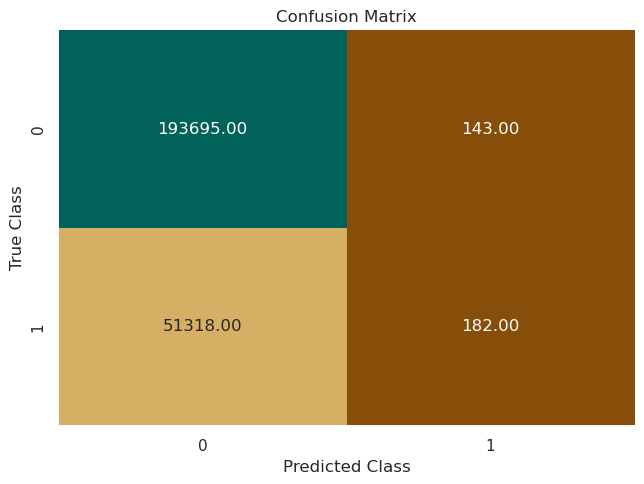

In [28]:
# Ploting Confusion Matrix
plot_confusion_matrix(test_labels, target_predicted)

Sensitivity or TPR: 0.3533980582524272 %
Specificity or TNR: 99.9262270555825 %
Precision: 56.00000000000001 %
Negative Predictive Value: 79.05498891895532 %
False Positive Rate: 0.07377294441750328 %
False Negative Rate: 99.64660194174758 %
False Discovery Rate: 44.0 %
Accuracy: 79.02444790452356 %
Validation AUC: 0.5013981255691746


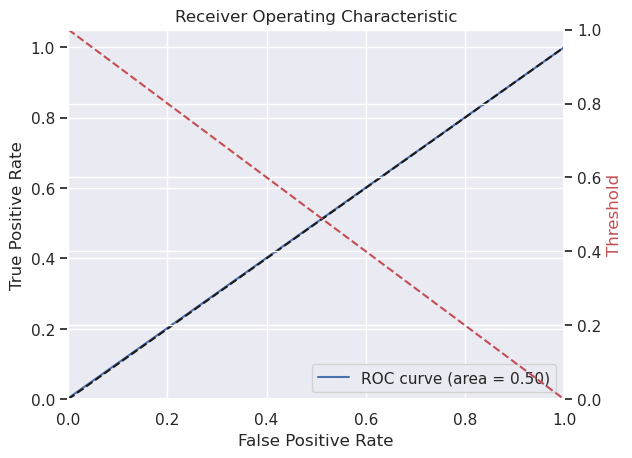

In [82]:
# Ploting ROC graph
plot_roc(test_labels, target_predicted)

### Train-test split for combined_csv_v2

In [69]:
train2, validate2, test2 = split_data(dataframe2)
print(train2['target'].value_counts())
print(test2['target'].value_counts())
print(validate2['target'].value_counts())

0.0    904581
1.0    240332
Name: target, dtype: int64
0.0    193838
1.0     51500
Name: target, dtype: int64
0.0    193839
1.0     51500
Name: target, dtype: int64


### LinearLearner Estimator for v2

In [71]:
import sagemaker
from sagemaker.serializers import CSVSerializer
from sagemaker.amazon.amazon_estimator import RecordSet
import boto3

# Instantiate the LinearLearner estimator object with 1 ml.m4.xlarge
classifier_estimator2 = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=1,
                                               instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier',
                                               binary_classifier_model_selection_criteria='cross_entropy_loss')

### Train, Validate and Test records creation for v2

In [72]:
# Create train, validate, and test records
train_records_v2 = classifier_estimator.record_set(train2.values[:, 1:].astype(np.float32), train2.values[:, 0].astype(np.float32), channel='train')
val_records_v2 = classifier_estimator.record_set(validate2.values[:, 1:].astype(np.float32), validate2.values[:, 0].astype(np.float32), channel='validation')
test_records_v2 = classifier_estimator.record_set(test2.values[:, 1:].astype(np.float32), test2.values[:, 0].astype(np.float32), channel='test')

In [ ]:
# Fit the classifier
classifier_estimator2.fit([train_records_v2, val_records_v2, test_records_v2])

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2024-11-02-15-06-45-687


2024-11-02 15:06:47 Starting - Starting the training job...
2024-11-02 15:07:00 Starting - Preparing the instances for training...
2024-11-02 15:07:25 Downloading - Downloading input data...
2024-11-02 15:08:11 Downloading - Downloading the training image......
2024-11-02 15:09:12 Training - Training image download completed. Training in progress....Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/02/2024 15:09:34 INFO 140384353838912] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss':

### Model Evaluation for V2

In [74]:
sagemaker.analytics.TrainingJobAnalytics(classifier_estimator._current_job_name, 
                                         metric_names = ['test:objective_loss', 
                                                         'test:binary_f_beta',
                                                         'test:precision',
                                                         'test:recall']
                                        ).dataframe()

,timestamp,metric_name,value
0,0.0,test:objective_loss,0.481037
1,0.0,test:binary_f_beta,0.102568
2,0.0,test:precision,0.570474
3,0.0,test:recall,0.056350


In [75]:
import io

prefix = 'fl_linear_v2'
train_file = 'fl_linear_train_v2.csv'
test_file = 'fl_linear_test_v2.csv'
validate_file = 'fl_linear_validate2.csv'
bucket = first_bucket

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [ ]:
test_labels2, target_predicted2 = batch_linear_predict(test2, classifier_estimator2)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2024-11-02-11-02-34-852
INFO:sagemaker:Creating transform job with name: linear-learner-2024-11-02-11-02-35-575


.............................................2024-11-02T11:10:14.921:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD

2024-11-02T11:10:14.921:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD


### Confusion Matrix for V2

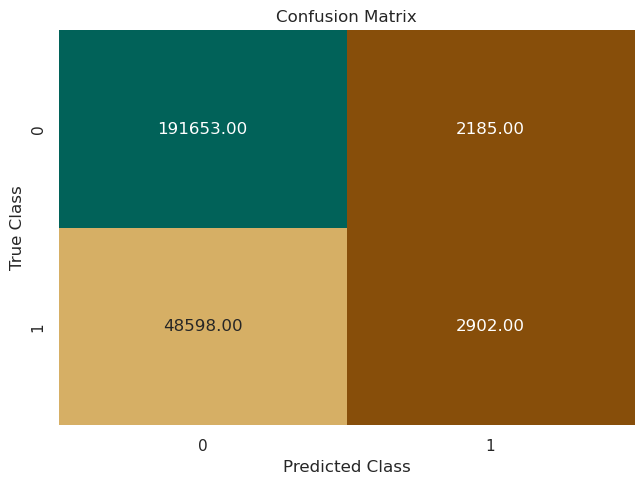

In [77]:
# Ploting Confusion Matrix
plot_confusion_matrix(test_labels2, target_predicted2)

### ROC Plot for V2

Sensitivity or TPR: 5.634951456310679 %
Specificity or TNR: 98.8727700450892 %
Precision: 57.04737566345587 %
Negative Predictive Value: 79.77198846206676 %
False Positive Rate: 1.1272299549108018 %
False Negative Rate: 94.36504854368933 %
False Discovery Rate: 42.95262433654413 %
Accuracy: 79.3008013434527 %
Validation AUC: 0.5225386075069993


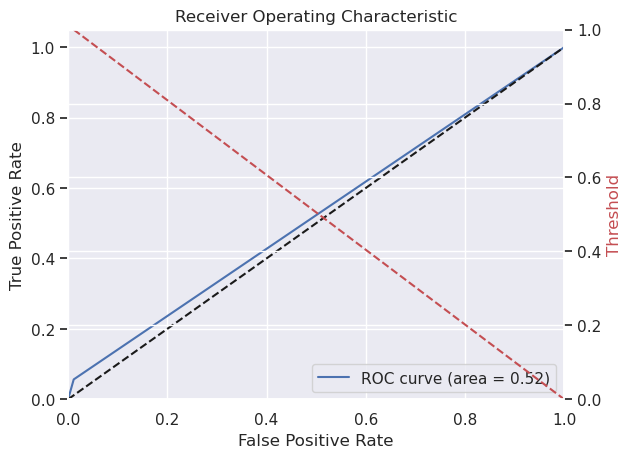

In [83]:
# Ploting ROC graph
plot_roc(test_labels2, target_predicted2)

## Step3: Try the XGBoost model

Performed these steps:  

1. Use the training set variables and save them as CSV files: train.csv, validation.csv and test.csv.
2. Store the bucket name in the variable. The Amazon S3 bucket name is provided to the left of the lab instructions.  
a. `bucket = <LabBucketName>`  
b. `prefix = 'flight-xgb'`  
3. Use the AWS SDK for Python (Boto3) to upload the model to the bucket.    

In [43]:
prefix = 'fl-xgb_v1'
train_file = 'fl-xgb_v1_train.csv'
test_file = 'fl-xgb_v1_test.csv'
validate_file = 'fl-xgb_v1_validate.csv'
whole_file = 'fl-xgb_v1.csv'
bucket = first_bucket

s3_resource = boto3.Session().resource('s3')

def upload_s3_csv2(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())


upload_s3_csv2(train_file, 'train', train)
upload_s3_csv2(test_file, 'test', test)
upload_s3_csv2(validate_file, 'validate', validate)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Use the `sagemaker.inputs.TrainingInput` function to create a `record_set` for the training and validation datasets.

In [44]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [45]:
from sagemaker.image_uris import retrieve

# Define the framework, region, and image version
framework = 'xgboost'
region = boto3.Session().region_name
version = '1.2-2'  # Use a more recent version if compatible

# Retrieve the container image URI
container = retrieve(framework, region, version)

# Print container URI to verify
print("Container URI:", container)


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Container URI: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-2


#### Sagemaker Estimator:

In [ ]:
sess = sagemaker.Session()
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)

xgb = sagemaker.estimator.Estimator(container,
                                    role = sagemaker.get_execution_role(), 
                                    instance_count=1, 
                                    instance_type=instance_type,
                                    output_path=s3_output_location,
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        eval_metric = "auc", 
                        num_round=100)

xgb.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-11-02-09-59-35-538


2024-11-02 09:59:36 Starting - Starting the training job...
2024-11-02 09:59:50 Starting - Preparing the instances for training...
2024-11-02 10:00:16 Downloading - Downloading input data...
2024-11-02 10:00:52 Downloading - Downloading the training image...
2024-11-02 10:01:38 Training - Training image download completed. Training in progress...[2024-11-02 10:01:49.234 ip-10-0-123-230.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:

Use the batch transformer for your new model, and evaluate the model on the test dataset.

In [ ]:
batch_X = test.iloc[:,1:];
batch_X_file='batch-in.csv'
upload_s3_csv2(batch_X_file, 'batch-in', batch_X)

In [ ]:
sess = sagemaker.Session()
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)

xgb = sagemaker.estimator.Estimator(container,
                                    role = sagemaker.get_execution_role(), 
                                    instance_count=1, 
                                    instance_type=instance_type,
                                    output_path=s3_output_location,
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        eval_metric = "auc", 
                        num_round=100)

xgb.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-11-02-09-59-35-538


2024-11-02 09:59:36 Starting - Starting the training job...
2024-11-02 09:59:50 Starting - Preparing the instances for training...
2024-11-02 10:00:16 Downloading - Downloading input data...
2024-11-02 10:00:52 Downloading - Downloading the training image...
2024-11-02 10:01:38 Training - Training image download completed. Training in progress...[2024-11-02 10:01:49.234 ip-10-0-123-230.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:

In [ ]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb.transformer(instance_count=1,
                                       instance_type=instance_type,
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-02-10-06-18-082
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-02-10-06-18-819


........................................[2024-11-02:10:12:52:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-02:10:12:52:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-02:10:12:52:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-11-02 10:12:52 +0000] [19] [INFO] Star

Get the predicted target and test labels.

In [ ]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['target'])
test_labels = test.iloc[:,0]

Calculate the predicted values based on the defined threshold.

**Note:** The predicted target will be a score, which must be converted to a binary class.

In [ ]:
print(target_predicted.head())

def binary_convert(x):
    threshold = 0.55
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['target'] = target_predicted['target'].apply(binary_convert)

test_labels = test_v1.iloc[:,0]

print(target_predicted.head())

   target
0       0
1       0
2       0
3       0
4       0
   target
0       0
1       0
2       0
3       0
4       0


Plot a confusion matrix for your `target_predicted` and `test_labels`.

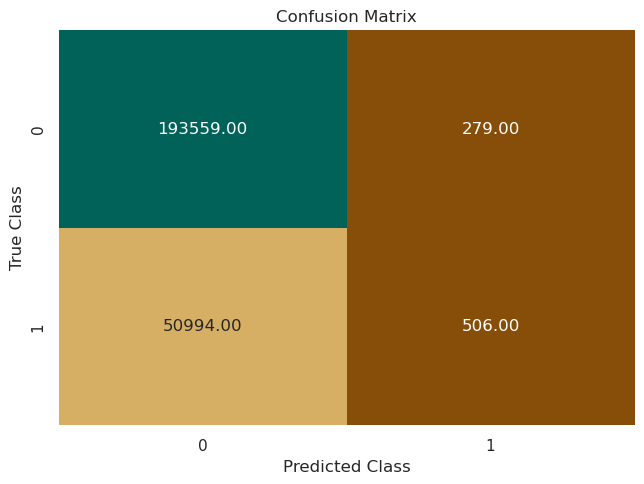

In [ ]:
plot_confusion_matrix(test_labels, target_predicted)

## Conclusion

#### On-Premises Approach
The on-premises approach proved advantageous for developing machine learning models due to the flexibility, responsiveness, and ease of environment customization it offers. Local machine processing power was sufficient for running code, especially with moderate to large datasets, enabling quick iterations without the delays encountered in cloud environments. Additionally, I could freely choose and configure my preferred IDE, facilitating smoother file and folder management. Code was easily managed with version control using GitHub, and missing dependencies were quickly installed with IDE prompts for any required libraries, which streamlined the development process. While the initial setup, including creating a virtual environment and installing dependencies, required time, this process was straightforward and involved minimal overhead once complete. Overall, the on-premises setup allowed for a smooth, efficient, and productive workflow.

#### Cloud-Based Approach (AWS SageMaker)
Working with AWS SageMaker offered a different experience with notable challenges, particularly around processing speed and stability. Processing was considerably slower when handling large datasets, as the kernel frequently terminated during operations, leading to interruptions and the need to restart from scratch. Data uploads and downloads for larger files were time-consuming, and the timed instance limits added further complexity. Once an instance’s time limit was reached, the setup process needed to be redone, often consuming another 30 minutes or more. The IDE’s performance also posed challenges: formatting issues persisted, code corrections were not always recognized, and basic features like Undo/Redo in Markdown cells were limited to within cells only, impacting productivity. Furthermore, the cloud environment’s billing structure meant each code execution incurred a cost, billed per second, which in real world could add pressure to complete tasks quickly and avoid redundant operations.

#### Overall Preference
While cloud-based solutions like AWS SageMaker can be powerful for large-scale data processing and model deployment, the on-premises setup offers a more efficient, flexible, and responsive environment for model development. Given AWS’s billing by execution time, on-premises development is a more cost-effective choice for iterative, code-heavy projects where rapid testing and debugging are essential.